<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2023/blob/main/notebooks/es7/AML_2023_HandsOn_8_GNN_for_Point_Cloud_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2022-2023
## Hands-on session 8

Dynamic Graph Neural Networks for the classification of 3D solid objects represented as point clouds, using pytorch-geometric

*   readout, pre-processing an visualization of pointclouds datasets in pytroch-geometric datasets
*   implementation of a PontNet++ GNN ([link](https://arxiv.org/abs/1706.02413)) model trained to classifiy 3D objects from the ShapeNet dataset ([link](http://web.stanford.edu/~ericyi/papers/part_annotation_16_small.pdf)


original code implementation from [pyg web-site](https://pytorch-geometric.readthedocs.io/en/latest/index.html).

[SLIDE](https://jamboard.google.com/d/1vHu2bKmZsYEBAygKhTYFo-CcOhVGQIAw8zSk55Ju9i8/edit?usp=sharing)

In [1]:
# Install required packages.
import os
import torch# for compatibility https://stackoverflow.com/questions/67285115/building-wheels-for-torch-sparse-in-colab-takes-forever
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster torch-spline-conv --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 17.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 14.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 26.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.1 MB/s eta 0:00:00
Looking 

### ShapeNet dataset 

available as benchmark dataset in pyg ([link](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.ShapeNet))

Contains about 17,000 3D shape point clouds from 16 shape categories. Each category is also segmented with 2 to 6 parts for segmentation tasks.


In [2]:
# read the dataset from pyg datasets

from torch_geometric.datasets import ShapeNet
dataset = ShapeNet(root='data/ShapeNet') #argument: where you want the dataset saved locally

print(dataset)
print(dataset[0])
print(dataset[0].x) #surface normal vectors to each point 
print(dataset[0].y) #segmentation labels (for each point)
print(dataset[0].pos) #coordinates of each point
print(dataset[0].category) #category

Extracting data/ShapeNet/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...
Done!


ShapeNet(14007, categories=['Airplane', 'Bag', 'Cap', 'Car', 'Chair', 'Earphone', 'Guitar', 'Knife', 'Lamp', 'Laptop', 'Motorbike', 'Mug', 'Pistol', 'Rocket', 'Skateboard', 'Table'])
Data(x=[2252, 3], y=[2252], pos=[2252, 3], category=[1])
tensor([[ 4.9600e-04, -4.5600e-04, -1.0000e+00],
        [ 8.9610e-01, -3.5990e-01,  2.5960e-01],
        [-2.5030e-01,  6.1500e-02, -9.6620e-01],
        ...,
        [ 2.9180e-01, -9.4380e-01, -1.5500e-01],
        [ 3.5150e-01, -8.8710e-01,  2.9930e-01],
        [ 3.0570e-01, -9.5010e-01,  6.2000e-02]])
tensor([23, 23, 22,  ..., 23, 23, 23])
tensor([[ 0.0000, -0.1885, -0.0005],
        [-0.0851, -0.1948,  0.0066],
        [-0.0364,  0.2399, -0.0057],
        ...,
        [ 0.0016, -0.0774, -0.0073],
        [ 0.0142, -0.0734,  0.0101],
        [ 0.0656, -0.0570,  0.0074]])
tensor([7])


In [4]:
dataset.categories

['Airplane',
 'Bag',
 'Cap',
 'Car',
 'Chair',
 'Earphone',
 'Guitar',
 'Knife',
 'Lamp',
 'Laptop',
 'Motorbike',
 'Mug',
 'Pistol',
 'Rocket',
 'Skateboard',
 'Table']

In [8]:
# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(10, 10))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')

    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    
    plt.axis('off')
    plt.show()

def visualize3d_points(pos,lab):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(pos[:, 0], pos[:, 2], pos[:,1], c=lab, s=50, zorder=1000)
    plt.axis('off')
    plt.show()

Data(x=[2705, 3], y=[2705], pos=[2705, 3], category=[1])
Table


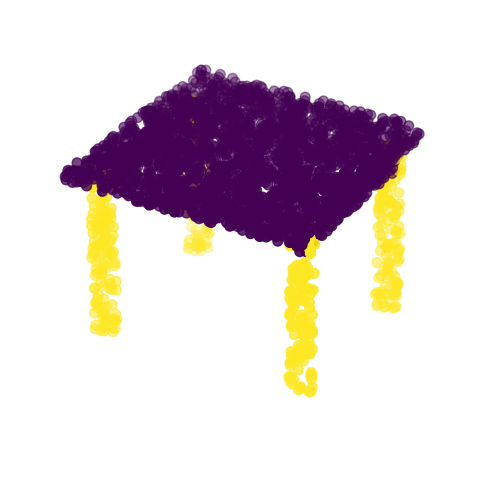

Data(x=[2500, 3], y=[2500], pos=[2500, 3], category=[1])
Chair


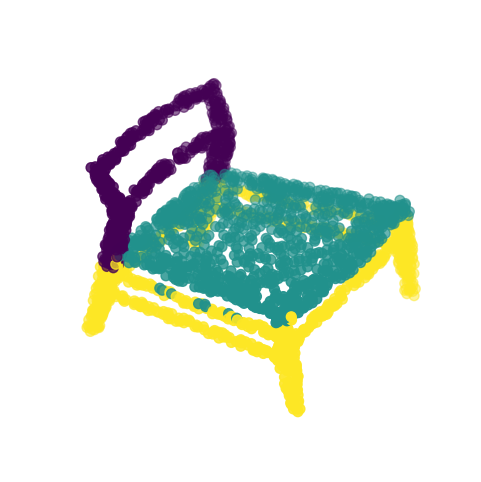

Data(x=[2736, 3], y=[2736], pos=[2736, 3], category=[1])
Chair


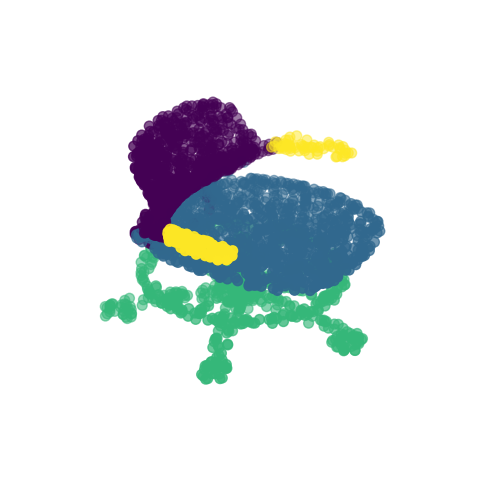

In [9]:
# visualize some examples

examples = [123,5,4]

for i in examples:
  data = dataset[i]
  print(data)
  print(dataset.categories[data.category.numpy()[0]])
  visualize3d_points(data.pos,data.y)

In [10]:
# the number of points in the dataset is too large to be used with the colab gpus and in a reasonable time, let's extract a subset of 100 
# point for each sample

from torch_geometric.loader import DataLoader
from torch_geometric.transforms import FixedPoints

train_dataset = ShapeNet(root='data/ShapeNet2', pre_transform=FixedPoints(num=100), split='trainval')
test_dataset = ShapeNet(root='data/ShapeNet2', pre_transform=FixedPoints(num=100), split='test')

# create pyg dataloaders 
train_loader = DataLoader(train_dataset, batch_size=10,  shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)


Extracting data/ShapeNet2/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...
Done!


Data(x=[100, 3], y=[100], pos=[100, 3], category=[1])
Table


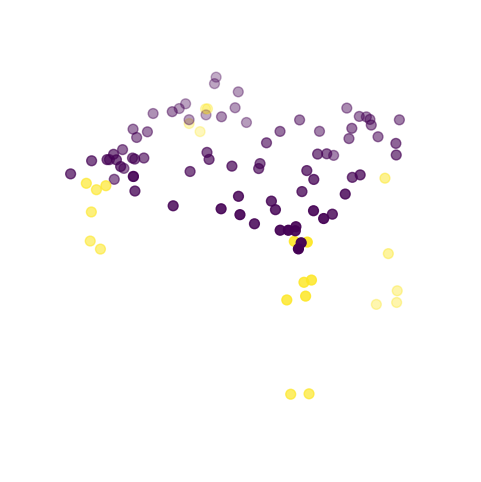

In [11]:
  data = train_dataset[123]
  print(data)
  print(train_dataset.categories[data.category.numpy()[0]])
  visualize3d_points(data.pos,data.y)

## PointNet++

Here, we will re-implement the **[PointNet++](https://arxiv.org/abs/1706.02413) architecture**, a pioneering work towards point cloud classification/segmentation via Graph Neural Networks.

PointNet++ processes point clouds iteratively by following a simple grouping, neighborhood aggregation and downsampling scheme:

1. The **grouping phase** constructs a graph in which nearby points are connected. Typically, this is either done via  $k$-nearest neighbor search or via ball queries (which connects all points that are within a radius to the query point).

2. The **neighborhood aggregation phase** executes a Graph Neural Network layer that, for each point, aggregates information from its direct neighbors (given by the graph constructed in the previous phase).
This allows PointNet++  to capture local context at different scales.

3. The **downsampling phase** implements a pooling scheme suitable for point clouds with potentially different sizes. 

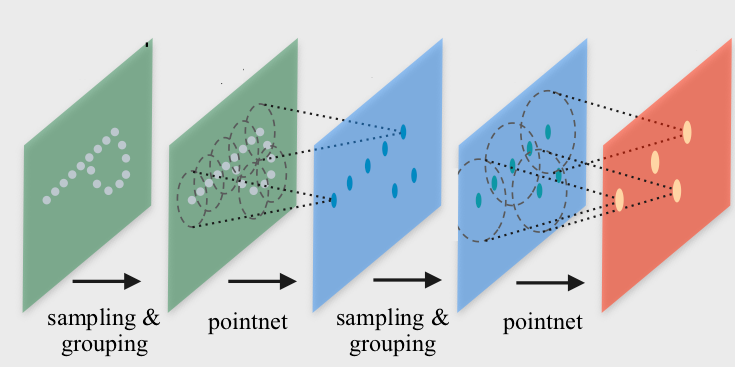

### Grouping via Dynamic Graph Generation

PyTorch Geometric provides utilities for dynamic graph generation via its helper package [`torch_cluster`](https://github.com/rusty1s/pytorch_cluster), in particular via the [`knn_graph`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.pool.knn_graph) and [`radius_graph`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.pool.radius_graph) functions for $k$-nearest neighbor and ball query graph generation, respectively.

Let's see the `knn_graph` functionality in action:

Here, we import the `knn_graph` function from `torch_cluster` and call it by passing in the input points `pos` and the number of nearest neighbors `k`.
As output, we will receive an `edge_index` tensor of shape `[2, num_edges]`, which will hold the information of source and target node indices in each column (known as the sparse matrix COO format).

torch.Size([2, 400])


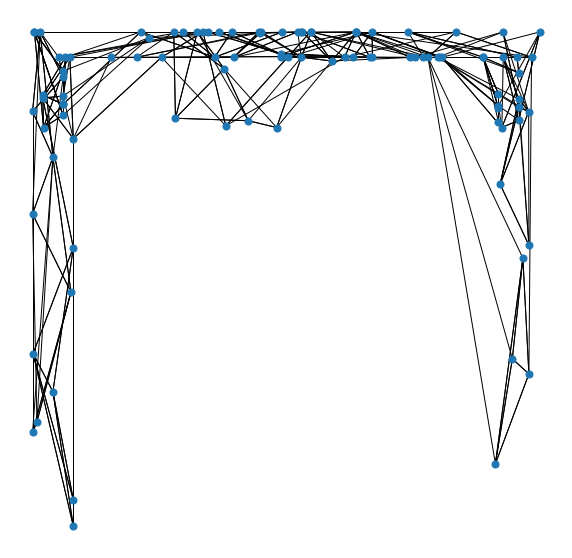

torch.Size([2, 400])


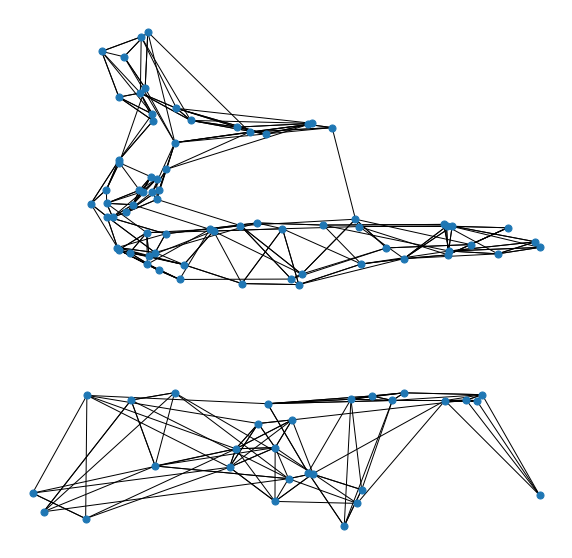

In [ ]:
from torch_cluster import knn_graph

data = train_dataset[123]
data.edge_index = knn_graph(data.pos, k=4)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

data = train_dataset[4]
data.edge_index = knn_graph(data.pos, k=4)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

## Phase 2: Neighborhood Aggregation

The **[PointNet++](https://arxiv.org/abs/1706.02413) layer** follows a simple *neural message passing scheme* defined via

$$
\mathbf{h}^{(\ell + 1)}_i = \max_{j \in \mathcal{N}(i)} \textrm{MLP} \left( \mathbf{h}_j^{(\ell)}, \mathbf{p}_j - \mathbf{p}_i \right)
$$
where
* $\mathbf{h}_i^{(\ell)} \in \mathbb{R}^d$ denotes the hidden features of point $i$ in layer $\ell$
* $\mathbf{p}_i \in \mathbb{R}^3$ denotes the position of point $i$.

We can make use of the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html) interface to implement this layer.
The `MessagePassing` interface helps us in **creating message passing graph neural networks** by automatically taking care of message propagation.
Here, we only need to define its `message` function as well as  which aggregation scheme to use, *e.g.*, `aggr="max"`.):

In [ ]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing


class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super().__init__(aggr='max')
        
        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=3).
        self.mlp = Sequential(Linear(in_channels + 3, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))
        
    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)
    
    def message(self, h_j, pos_j, pos_i):
        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3]

        input = pos_j - pos_i  # Compute spatial relation.

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)

        return self.mlp(input)  # Apply our final MLP.

As one can see, implementing the PointNet++ layer is quite straightforward in PyTorch Geometric.
In the `__init__` function, we first define that we want to apply **`max` aggregation**, and afterwards initialize an MLP that takes care of transforming neighboring node features and the spatial relation between source and destination nodes to a (trainable) message.

In the `forward` function, we can start **propagating messages** based on `edge_index`, and pass in everything needed in order to create messages.
In the `message` function, we can now access neighboring and central node information via `*_j` and `*_i`, respectively, and return a message for each edge.

## Network Architecture

We can make use of `knn_graph` and the `PointNetLayer` to define our network architecture.
Here, we are interested in an architecture that is able to operate on point clouds in a **mini-batch fashion**.
PyTorch Geometric achieves parallelization over mini-batches by creating sparse block diagonal adjacency matrices (defined by `edge_index`) and concatenating feature matrices in the node dimension (such as `pos`).
For distinguishing examples in a mini-batch, there exists a special vector named [**`batch`**](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#mini-batches) of shape `[num_nodes]`, which maps each node to its respective graph in the batch:
$$
\textrm{batch} = {[ 0 \cdots 0, 1 \cdots n-2 n-1 \cdots n - 1 ]}^{\top}
$$

We need to make use of this `batch` vector for the `knn_graph` generation since we do not want to connect nodes from different examples.

With this, our overall `PointNet` architecture looks as follows:

In [ ]:
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool


class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, 16) #16 number of ouput categories
        
    def forward(self, pos, batch):
        # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)
        
        # 3. Start message passing.
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # 4. Global Pooling.
        h = global_max_pool(h, batch)  # [num_examples, hidden_channels]
        
        # 5. Classifier.
        return self.classifier(h)


model = PointNet()
print(model)

PointNet(
  (conv1): PointNetLayer()
  (conv2): PointNetLayer()
  (classifier): Linear(in_features=32, out_features=16, bias=True)
)


Here, we create our network architecture by inheriting from **`torch.nn.Module`** and initialize **two `PointNetLayer` modules** and a **final linear classifier** ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) in its constructor.

In the `forward` method, we first dynamically generate a **16-nearest neighbor graph** based on the position `pos` of nodes.
Based on the resulting graph connectivity, we apply two graph-based convolutional operators and enhance them by ReLU non-linearities.
The first operator takes in 3 input features (the positions of nodes) and maps them to 32 output features.

After that, each point holds information about **its 2-hop neighborhood**, and should already be able to distinguish between simple local shapes.

Next, we apply a **global graph readout function**, *i.e.*, `global_max_pool`, which takes the maximum value along the node dimension for each example.
Last, we apply a linear classifier to map the remaining 32 features to **one of the 40 classes**.

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = PointNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.

model.to('cuda')

def train(model, optimizer, loader):
    model.train()
    
    total_loss = 0
    for data in loader:
        data.to('cuda')
        optimizer.zero_grad()  # Clear gradients.
        logits = model(data.pos, data.batch)  # Forward pass.
        loss = criterion(logits, data.category) # Loss computation. (note data.y returns the segmentation labels)
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data.to('cuda')
        logits = model(data.pos, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.category).sum())

    return total_correct / len(loader.dataset)

for epoch in range(1, 11):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 01, Loss: 0.6131, Test Accuracy: 0.8730
Epoch: 02, Loss: 0.2341, Test Accuracy: 0.9245
Epoch: 03, Loss: 0.1843, Test Accuracy: 0.9429
Epoch: 04, Loss: 0.1722, Test Accuracy: 0.9381
Epoch: 05, Loss: 0.1574, Test Accuracy: 0.9412
Epoch: 06, Loss: 0.1339, Test Accuracy: 0.9555
Epoch: 07, Loss: 0.1517, Test Accuracy: 0.9565
Epoch: 08, Loss: 0.1294, Test Accuracy: 0.9346
Epoch: 09, Loss: 0.1380, Test Accuracy: 0.9509
Epoch: 10, Loss: 0.1342, Test Accuracy: 0.9461


As one can see, we are able to achieve around **~95% test accuracy** with few eopchs.

**However, there is one caveat:**
Since PointNet++ model takes in node positions as input features, and uses relational Cartesian coordinates for creating messages, *i.e.* $\mathbf{p}_j - \mathbf{p}_i$, it does not generalize across different rotations applied to the input point cloud.

Let's verify this in an example, where we apply random rotations to the test data by composing [`RandomRotate`](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.RandomRotate) transformations along different axes:

In [ ]:

from torch_geometric.transforms import Compose, RandomRotate
torch.manual_seed(42)

random_rotate = Compose([
    RandomRotate(degrees=20, axis=0),
    RandomRotate(degrees=20, axis=1),
    RandomRotate(degrees=20, axis=2),
])

transform = Compose([
    random_rotate,
    FixedPoints(num=100),
])

test_dataset = ShapeNet(root='data/ShapeNet3', transform=transform, split='test')
test_loader = DataLoader(test_dataset, batch_size=10)

test_acc = test(model, test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

Extracting data/ShapeNet3/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...
Done!


Test Accuracy: 0.8337


### Home exercises

1.   play with the model and input point cloud, how perfromaces changes with a smaller numebr of points? 
2.   try to change the model using tthe builtin *PointNetConv* layer of pytorch geometric
2.   Rotation-invariant PointNet Layer:

The **[PPFNet](https://arxiv.org/abs/1802.02669)** is an extension to the PointNet++ architecture that makes it **rotation-invariant**.
More specifically, PPF stands for **Point Pair Feature**, which describes the relation between two points by a rotation-invariant 4D descriptor
$$
\left( \| \mathbf{p}_j - \mathbf{p}_i \|_2, \angle(\mathbf{n}_i, \mathbf{p}_j - \mathbf{p}_i), \angle(\mathbf{n}_j, \mathbf{p}_j - \mathbf{p}_i), \angle(\mathbf{n}_i, \mathbf{n}_j) \right)
$$
based on
1. the distance between points $\| \mathbf{p}_j - \mathbf{p}_i \|_2$ and
2. the angles between $\mathbf{p}_j - \mathbf{p}_i$ and the **normal vectors** $\mathbf{n}_i$ and $\mathbf{n}_j$ of points $i$ and $j$, respectively.

In addition to the [`PointNetConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.PointNetConv), PyTorch Geometric also provides an implementation of the `PointConv` based on the Point Pair Feature descriptor, see **[`PPFConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.PPFConv)**.
Furthermore, the [`SamplePoints`](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html) transformation does also provide **normal vectors** in `data.normal` for each sampled point when called via `SamplePoints(num_points, include_normals=True)`.

As an exercise, you can try to extend the example code below in order to instantiate the `PPFConv` modules.
The `PPFConv` expects an MLP as first argument, which is similar to the one created earlier in the `PointNetLayer`.

4.Implement the Downsampling Phase via Farthest Point Sampling in PointNet++:

In the PointNet++ architecture, downsampling of a point clouds is achieved via the **Farthest Point Sampling** (FPS) procedure, which, in return, allows the network to extract more and more global features.
Given an input point set $\{ \mathbf{p}_1, \ldots \mathbf{p}_n \}$, FPS iteratively selects a subset of points such that the sampled points are furthest apart.
Specifically, compared with random sampling, this procedure is known to have better coverage of the entire point set.

PyTorch Geometric provides a ready-to-use implementation of [`fps`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.pool.fps), which takes in the position of nodes and a sampling ratio, and returns the indices of nodes that have been sampled:

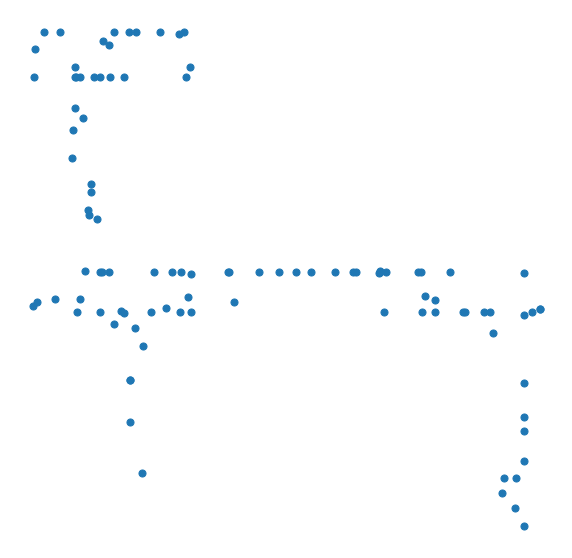

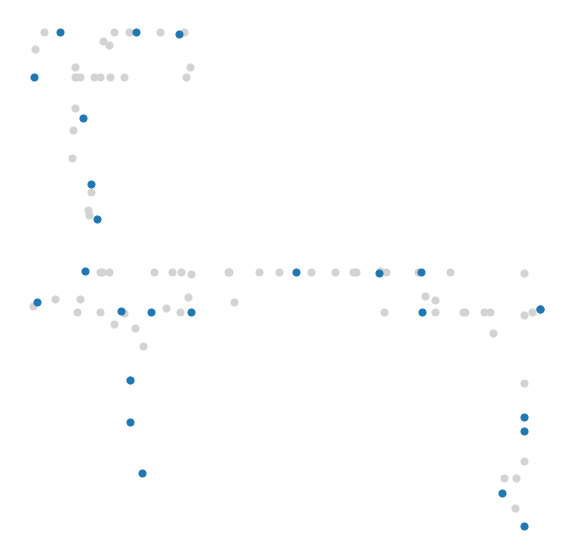

In [ ]:
from torch_cluster import fps

data = test_dataset[0]
index = fps(data.pos, ratio=0.25)

visualize_points(data.pos)
visualize_points(data.pos, index=index)


The exercise would be to modify the `PPFNet` model to include a farthest point sampling step (`ratio=0.5`) in between the two convolution operators.

Note that for `fps`, you also need to pass in the `batch` vector, so that points in different examples are sampled independently from each other:
```
index = fps(pos, batch, ratio=0.5)
```
You can now pool the points, their normals, the features and the batch vector via:
```
pos = pos[index]
normal = normal[index]
h = h[index]
batch = batch[index]
```
This will just keep the points sampled by `fps`.

Note that you also need to create a new $k$-NN graph after applying the pooling operation.

In [ ]:
# example of skeleton of PPFNet model

from torch_geometric.nn import PPFConv
from torch_cluster import fps


class PPFNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        torch.manual_seed(12345)
        self.mlp1 = Sequential(Linear(in_channels + 3, out_channels),
                               ReLU(),
                               Linear(out_channels, out_channels))
        self.mlp1 = Sequential(Linear(in_channels + 3, out_channels),
                               ReLU(),
                               Linear(out_channels, out_channels))
        mlp1 = ...  # TODO
        self.conv1 = PPFConv(...)  # TODO
        mlp2 = ...  # TODO
        self.conv2 = PPFConv(...)  # TODO
        self.classifier = Linear(32, dataset.num_classes)
        
    def forward(self, pos, normal, batch):
        edge_index = knn_graph(pos, k=16, batch=batch, loop=False)
        
        x = self.conv1(x=None, pos=pos, normal=normal, edge_index=edge_index)
        x = x.relu()
        x = self.conv2(x=x, pos=pos, normal=normal, edge_index=edge_index)
        x = x.relu()

        x = global_max_pool(x, batch)  # [num_examples, hidden_channels]
        return self.classifier(x)


model = PPFNet()
print(model)

PPFNet(
  (conv1): PPFConv(local_nn=Ellipsis, global_nn=None)
  (conv2): PPFConv(local_nn=Ellipsis, global_nn=None)
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)


In [ ]:
model = PPFNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.

def train2(model, optimizer, loader):
    model.train()
    
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        logits = model(data.pos, data.x, data.batch)
        loss = criterion(logits, data.category)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test2(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        logits = model(data.pos, data.x, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.category).sum())

    return total_correct / len(loader.dataset)

for epoch in range(1, 101):
    loss = train2(model, optimizer, train_loader)
    test_acc = test2(model, test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')